    2 реализации
    - эмбеддинги + билстм. Эмбеддинги получены с помощью BPE.
    - эмбеддинги+билстм склеенные к билстм. Эмбеддинги получены с помощью BPE.
    
    В качестве входных данных использовались последовательности длинной от 5 до 30 символов и предсказывался следующий символ, те бралась только информация слева.

1 версия

`(train 0.59, val 0.55, test 0.55)`
`(эпох 160, батч 200)`

2 версия

`(train 0.4430, val 0.4325, test 0.44)`
`(эпох 160, батч 200)`

### Libraries

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import LSTM, Bidirectional, Embedding, Input, Concatenate, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
curruser = os.environ.get('USER')

from keras.backend.tensorflow_backend import set_session
from keras import backend as K
import tensorflow as tf

import pandas as pd
import numpy as np
import bpe

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from pylab import rcParams
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


### Set GPU

In [3]:
with K.tf.device('/GPU:0'):
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    session = tf.Session(config=config)
    K.set_session(session)

### Secondary functions

In [4]:
def plot_metrics(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.figure()
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [3]:
def confusion_matrix_heatmap(y_true, y_pred):
    '''
    Построение Confusion matrix (матрицы ошибок)

    Parameters
    ----------
    y_test: pandas.Series, numpy.array
        Целевая для обучающего набора
    y_pred: pandas.Series, numpy.array
        Значения целевой переменной, предсказанные классификатором
    '''
    rcParams['figure.figsize'] = 6, 4
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Load dataset and preproc

In [4]:
data = pd.read_csv('./data/LeftWrap_5to30.csv', sep=';')
data.head(5)

,seq,label
0,ACGGCTGGAGCCCATGTTCAGCATGAAAAC,A
1,TAAATTTCTGGATGGCAATGAAATGACATT,A
2,TCCACTTGGCAGCCAAATATGGCCAGACAA,A
3,CGGAGGAGAGCACCGAGCCCCTGAGTGAGG,A
4,GGACCACATTTGGGGAGCTTGCCATTTTAT,A


In [5]:
encoder = bpe.Encoder.load('./same_/bpe_tokenizer.h5')

In [8]:
encoder.bpe_vocab, encoder.bpe_vocab_size, encoder.word_vocab, encoder.vocab_size

({'__sow': 250,
  '__eow': 251,
  'g': 252,
  'a': 253,
  'c': 254,
  't': 255,
  'ag': 256,
  'ca': 257,
  'tg': 258,
  'cc': 259,
  'ga': 260,
  'gg': 261,
  'aa': 262,
  'ct': 263,
  'gc': 264,
  'tc': 265,
  'ac': 266,
  'at': 267,
  'tt': 268,
  'gt': 269,
  'ta': 270,
  'cg': 271,
  'cag': 272,
  'ctg': 273,
  'aga': 274,
  'tgg': 275,
  'cca': 276,
  'gga': 277,
  'gaa': 278,
  'gag': 279,
  'aag': 280,
  'cct': 281,
  'aaa': 282,
  'gcc': 283,
  'agc': 284,
  'ccc': 285,
  'agg': 286,
  'tga': 287,
  'ggc': 288,
  'gct': 289,
  'gca': 290,
  'tgc': 291,
  'caa': 292,
  'atg': 293,
  'aca': 294,
  'tca': 295,
  'gtg': 296,
  'tcc': 297,
  'ctc': 298,
  'acc': 299,
  'ggg': 300,
  'cac': 301,
  'tct': 302,
  'ttc': 303,
  'ctt': 304,
  'cat': 305,
  'gac': 306,
  'tgt': 307,
  'gat': 308,
  'aac': 309,
  'ttt': 310,
  'agt': 311,
  'ttg': 312,
  'atc': 313,
  'act': 314,
  'aat': 315,
  'att': 316,
  'ggt': 317,
  'gtc': 318,
  'ccg': 319,
  'cgg': 320,
  'gtt': 321,
  'tac': 322

In [6]:
def tokens_to_ids(encoder, x):
    x_toks = []
    for i in range(len(x)):
        encoder.tokenize(x[i])
        x_toks.append(next(encoder.transform([x[i]])))
    
    max_len = max(map(len, x_toks))
    X_arr = np.zeros((len(x_toks), max_len), dtype='int32')
    for i, s in enumerate(x_toks):
        X_arr[i, 0:len(s)] = s
    
    return X_arr

In [7]:
X_toks = tokens_to_ids(encoder, data.seq.values)

max(map(max,X_toks)), min(map(min,X_toks))

(499, 0)

In [8]:
chars = sorted(list(set(data.label.values)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

y_ids = np.zeros((len(data.label.values), len(chars)), dtype=np.bool)
for i, label in enumerate(data.label.values):
    y_ids[i, char_indices[data.label.values[i]]] = 1

In [9]:
X_toks[:5], y_ids[:5]

(array([[251, 349, 329, 373, 431, 321, 324, 376, 447, 250,   0,   0],
        [251, 343, 476, 496, 364, 426, 423, 407, 268, 250,   0,   0],
        [251, 380, 474, 338, 395, 339, 364, 342, 292, 250,   0,   0],
        [251, 320, 337, 373, 299, 373, 389, 479, 345, 250,   0,   0],
        [251, 408, 415, 434, 406, 472, 359, 471, 267, 250,   0,   0]],
       dtype=int32), array([[ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]]))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_toks, y_ids, 
                                                    random_state=42, shuffle=True, test_size=0.2)

# Build model: Emb+Bilstm+batchnorm

In [18]:
def get_model(vocab_size, seq_len):

    model = Sequential()
    
    model.add(Embedding(vocab_size+1, 128, input_length=seq_len))

    model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout = 0.2)))
    
    model.add(BatchNormalization())
    
    model.add(Flatten())

    model.add(Dense(1024))
    model.add(Activation('tanh'))
    
    model.add(Dense(4))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [7]:
model = get_model(encoder.vocab_size, X_train.shape[1])
#plot_model(model = model, to_file = './same_/BiLSTM+emb.png', show_layer_names=False, show_shapes=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
path = './same_/bilstm_emb.h5'

callbacks = [EarlyStopping(patience=12, monitor='val_loss'),
                 ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

BATCH_SIZE=200
n_epoch=160

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epoch, shuffle=True,
                     validation_split=0.2, verbose=1, callbacks=callbacks).history

Instructions for updating:
Use tf.cast instead.
Train on 2144864 samples, validate on 536217 samples
Epoch 1/160
2144864/2144864 [==============================] - 602s 281us/step - loss: 1.3359 - acc: 0.3443 - val_loss: 1.3221 - val_acc: 0.3532

Epoch 00001: val_loss improved from inf to 1.32206, saving model to ./same_/bilstm_emb.h5
Epoch 2/160
2144864/2144864 [==============================] - 597s 279us/step - loss: 1.3151 - acc: 0.3609 - val_loss: 1.3134 - val_acc: 0.3604

Epoch 00002: val_loss improved from 1.32206 to 1.31335, saving model to ./same_/bilstm_emb.h5
Epoch 3/160
2144864/2144864 [==============================] - 598s 279us/step - loss: 1.3069 - acc: 0.3695 - val_loss: 1.3030 - val_acc: 0.3727

Epoch 00003: val_loss improved from 1.31335 to 1.30304, saving model to ./same_/bilstm_emb.h5
Epoch 4/160
2144864/2144864 [==============================] - 603s 281us/step - loss: 1.3013 - acc: 0.3758 - val_loss: 1.3044 - val_acc: 0.3757

Epoch 00004: val_loss did not improve

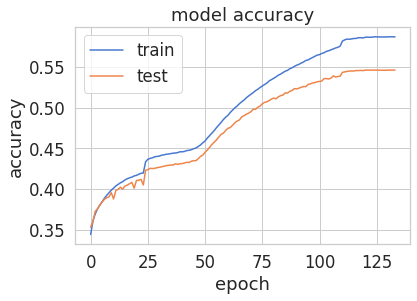

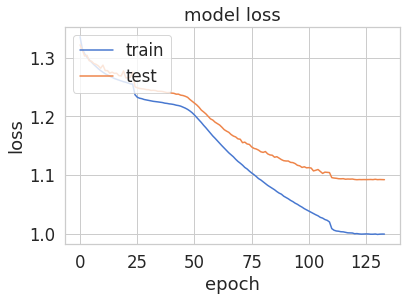

In [25]:
plot_metrics(history)

# OOB validation

In [19]:
model = load_model(path)

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

y_true = y_test.argmax(axis=-1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


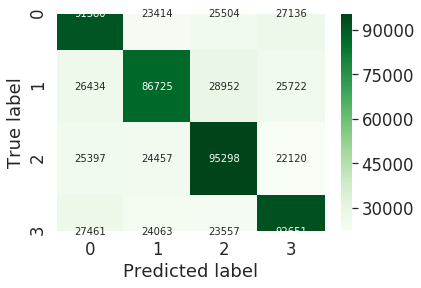

In [27]:
confusion_matrix_heatmap(y_true, y_pred)

In [28]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.55      0.54    167434
           1       0.55      0.52      0.53    167833
           2       0.55      0.57      0.56    167272
           3       0.55      0.55      0.55    167732

    accuracy                           0.55    670271
   macro avg       0.55      0.55      0.55    670271
weighted avg       0.55      0.55      0.55    670271



# Modify architecture on the same data and train

In [13]:
def get_model(vocab_size, seq_len):

    inp = Input(shape =(seq_len,))
    emb = Embedding(vocab_size+1, 128)(inp)
    x = Bidirectional(LSTM(units=128, return_sequences=True, dropout = 0.2))(emb)
    inp_ = Reshape(target_shape=(seq_len,1))(inp)
    xlstm = Concatenate()([x,inp_])
    x = Bidirectional(LSTM(units=128, dropout=0.1, recurrent_dropout=0.1, 
                           return_sequences=False))(xlstm) 

    x = BatchNormalization()(x)

    x = Dense(128)(x)
    x = Activation('tanh')(x)
    
    x = Dropout(0.1)(x)
    
    outp = Dense(4, activation = 'softmax')(x)
    
    model = Model(inp, outp)
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

In [14]:
model = get_model(encoder.vocab_size, X_train.shape[1])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 12, 128)      64128       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 12, 256)      263168      embedding_1[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)  

In [16]:
path = './same_/bilstm_emb_v2.h5'

callbacks = [EarlyStopping(patience=12, monitor='val_loss'),
                 ModelCheckpoint(path, monitor='val_loss', verbose=1, save_best_only=True),
                 ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)]

BATCH_SIZE=200
n_epoch=160

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epoch, shuffle=True,
                     validation_split=0.2, verbose=1, callbacks=callbacks).history

Instructions for updating:
Use tf.cast instead.
Train on 2144864 samples, validate on 536217 samples
Epoch 1/160
2144864/2144864 [==============================] - 1400s 653us/step - loss: 1.3335 - acc: 0.3411 - val_loss: 1.3207 - val_acc: 0.3561

Epoch 00001: val_loss improved from inf to 1.32071, saving model to ./same_/bilstm_emb_v2.h5
Epoch 2/160
2144864/2144864 [==============================] - 1371s 639us/step - loss: 1.3110 - acc: 0.3633 - val_loss: 1.3042 - val_acc: 0.3698

Epoch 00002: val_loss improved from 1.32071 to 1.30418, saving model to ./same_/bilstm_emb_v2.h5
Epoch 3/160
2144864/2144864 [==============================] - 1373s 640us/step - loss: 1.2983 - acc: 0.3773 - val_loss: 1.2944 - val_acc: 0.3802

Epoch 00003: val_loss improved from 1.30418 to 1.29438, saving model to ./same_/bilstm_emb_v2.h5
Epoch 4/160
2144864/2144864 [==============================] - 1372s 640us/step - loss: 1.2900 - acc: 0.3856 - val_loss: 1.2883 - val_acc: 0.3875

Epoch 00004: val_loss im

2144864/2144864 [==============================] - 1360s 634us/step - loss: 1.2297 - acc: 0.4353 - val_loss: 1.2395 - val_acc: 0.4267

Epoch 00034: val_loss improved from 1.23975 to 1.23945, saving model to ./same_/bilstm_emb_v2.h5
Epoch 35/160
2144864/2144864 [==============================] - 1373s 640us/step - loss: 1.2294 - acc: 0.4354 - val_loss: 1.2394 - val_acc: 0.4271

Epoch 00035: val_loss improved from 1.23945 to 1.23940, saving model to ./same_/bilstm_emb_v2.h5
Epoch 36/160
2144864/2144864 [==============================] - 1371s 639us/step - loss: 1.2289 - acc: 0.4362 - val_loss: 1.2384 - val_acc: 0.4274

Epoch 00036: val_loss improved from 1.23940 to 1.23841, saving model to ./same_/bilstm_emb_v2.h5
Epoch 37/160
2144864/2144864 [==============================] - 1369s 638us/step - loss: 1.2284 - acc: 0.4362 - val_loss: 1.2382 - val_acc: 0.4273

Epoch 00037: val_loss improved from 1.23841 to 1.23822, saving model to ./same_/bilstm_emb_v2.h5
Epoch 38/160
2144864/2144864 [===

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2144864/2144864 [==============================] - 1372s 639us/step - loss: 1.2229 - acc: 0.4406 - val_loss: 1.2336 - val_acc: 0.4314

Epoch 00053: val_loss improved from 1.23396 to 1.23359, saving model to ./same_/bilstm_emb_v2.h5
Epoch 54/160
2144864/2144864 [==============================] - 1381s 644us/step - loss: 1.2229 - acc: 0.4411 - val_loss: 1.2340 - val_acc: 0.4315

Epoch 00054: val_loss did not improve from 1.23359
Epoch 55/160
2144864/2144864 [==============================] - 1368s 638us/step - loss: 1.2226 - acc: 0.4408 - val_loss: 1.2337 - val_acc: 0.4315

Epoch 00055: val_loss did not improve from 1.23359
Epoch 56/160
2144864/2144864 [==============================] - 1371s 639us/step - loss: 1.2222 - acc: 0.4412 - val_loss: 1.2338 - val_acc: 0.4316

Epoch 00056: val_loss did not improve from 1.23359

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 57/160
2144864/2144864 [==============================] - 1372s 640us/step - loss: 

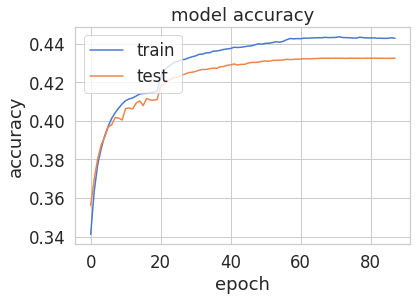

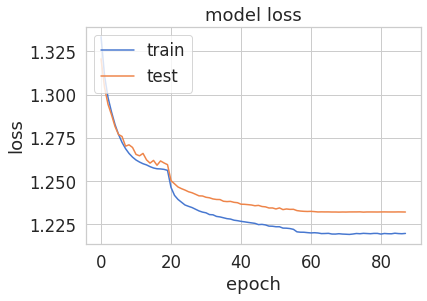

In [17]:
plot_metrics(history)

In [11]:
model = load_model('./same_/bilstm_emb_v2.h5')

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)

y_true = y_test.argmax(axis=-1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


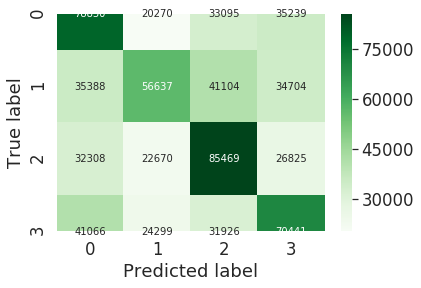

In [12]:
confusion_matrix_heatmap(y_true, y_pred)

In [13]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.47      0.44    167434
           1       0.46      0.34      0.39    167833
           2       0.45      0.51      0.48    167272
           3       0.42      0.42      0.42    167732

    accuracy                           0.43    670271
   macro avg       0.44      0.43      0.43    670271
weighted avg       0.44      0.43      0.43    670271

